In [1]:
import datetime
import pandas
import feather
import seaborn as sns
from davitpy import pydarn
from davitpy import gme
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.colors import Normalize
from matplotlib import ticker
from matplotlib.dates import date2num, DateFormatter, MinuteLocator
from matplotlib.ticker import FuncFormatter, MaxNLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
startDate = datetime.datetime(2011,7,5,3,0)#datetime.datetime(2011,5,16,7,30)#datetime.datetime(2011,6,8,2,0)#
endDate = datetime.datetime(2011,7,5,7,0)#datetime.datetime(2011,5,16,9,30)#datetime.datetime(2011,6,8,8,0)#

selDtList =  [ datetime.datetime(2011,7,5,3,30),\
              datetime.datetime(2011,7,5,4,5),\
             datetime.datetime(2011,7,5,5,40) ]
gmagTimeRange = [ datetime.datetime(2011,7,4,0,0),\
                 datetime.datetime(2011,7,5,23,59) ]

# [ datetime.datetime(2011,6,8,4,30), datetime.datetime(2011,6,8,4,0), datetime.datetime(2011,6,8,6,0) ]#


# [ datetime.datetime(2011,5,16,8,0), datetime.datetime(2011,5,16,8,15),\
#                          datetime.datetime(2011,5,16,9,0) ]#

In [3]:
sapsRadList = [ "cvw" ]#[ "fhw" ]
selBeam = 17#9
sapsMlatRange = [ 52., 62. ]#[ 56., 60. ]
sapsVelCutoff = 50.
sapsNpointsCutoff = 50 # per radar per beam
velScale = [ -300, 300 ]

In [4]:
# TEC constants
tecScale = [ 2, 10 ]
trghLatRange = [ 50, 65 ]

In [5]:
# read from the feather file
velsDF = feather.read_dataframe('../data/saps-' +\
                startDate.strftime("%Y%m%d") + '.feather')
velsDF.head()

,dateStr,timeStr,beam,range,azimCalcMag,vLos,MLAT,MLON,MLT,GLAT,GLON,radId,radCode,date,normMLT
0,20110705,300,0,0,-7.8204,21.1500,39.2439,-145.2032,12.4690,44.3894,143.4903,40,hok,2011-07-05 03:00:00,-11.5310
1,20110705,300,0,1,-4.6284,18.5725,39.7470,-145.0795,12.4772,44.9081,143.6445,40,hok,2011-07-05 03:00:00,-11.5228
2,20110705,300,0,2,-2.9119,19.8473,40.1949,-144.9959,12.4828,45.3684,143.7537,40,hok,2011-07-05 03:00:00,-11.5172
3,20110705,300,0,3,-1.7818,5.4916,40.6224,-144.9279,12.4874,45.8067,143.8465,40,hok,2011-07-05 03:00:00,-11.5126
4,20110705,300,0,4,-0.9696,-0.8002,41.0394,-144.8684,12.4913,46.2334,143.9308,40,hok,2011-07-05 03:00:00,-11.5087


In [6]:
# get data ready for a rti plot
# sel data from a radar
rtiDF = velsDF[ (velsDF["radCode"] == sapsRadList[0]) &\
              (velsDF["beam"] == selBeam) ]
rtiDF["dtNum"] = [ date2num(x) for x in rtiDF["date"] ]
plotDF = rtiDF[ ["MLAT", "dtNum",\
                        "vLos"] ].pivot( "MLAT", "dtNum" )
mlatVals = plotDF.index.values
timeVals = plotDF.columns.levels[1].values

timeCntr, mlatCntr  = numpy.meshgrid( timeVals, mlatVals )
# Mask the nan values! pcolormesh can't handle them well!
vLosVals = numpy.ma.masked_where(numpy.isnan(plotDF["vLos"].values),plotDF["vLos"].values)
# setup cmap
velSeaMap = ListedColormap(sns.color_palette("coolwarm_r"))

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [7]:
def convert_to_datetime(row):
    return datetime.datetime( \
        startDate.year, startDate.month,\
        startDate.day, int(row["HH"]), int(row["MM"]) )

In [8]:
# Read wp index data
wpFName = "../data/wp_" + endDate.strftime("%Y%m%d") + ".txt"
wpDF = pandas.read_csv(wpFName, delim_whitespace=True)
wpDF["date"] = wpDF.apply( convert_to_datetime, axis=1 )

In [9]:
# read data from different sources
# OMNI data
omnData=gme.ind.omni.readOmni(gmagTimeRange[0], gmagTimeRange[1])
# AE data
aeData=gme.ind.readAe(gmagTimeRange[0], gmagTimeRange[1], res=1)
#Now we do the SYM and ASYM indices...
symasy=gme.ind.symasy.readSymAsy(\
        sTime=gmagTimeRange[0], eTime=gmagTimeRange[1],\
        symh=None, symd=None, asyh=None,\
        asyd=None)
# convert to dataframes
omnDF = pandas.DataFrame( {'date' : [ omnData[x].time for x in range(len(omnData))],
                           'ief' : [ omnData[x].e for x in range(len(omnData))],
                          'Bz' : [ omnData[x].bzm for x in range(len(omnData))] } )
aeDF = pandas.DataFrame( {'date' : [ aeData[x].time for x in range(len(aeData))],
                           'ae' : [ aeData[x].ae for x in range(len(aeData))],
                          'ao' : [ aeData[x].ao for x in range(len(aeData))],
                          'au' : [ aeData[x].au for x in range(len(aeData))],
                          'al' : [ aeData[x].al for x in range(len(aeData))] } )
symDF = pandas.DataFrame( {'date' : [ symasy[x].time for x in range(len(symasy))],
                           'symh' : [ symasy[x].symh for x in range(len(symasy))],
                          'asyh' : [ symasy[x].asyh for x in range(len(symasy))],
                          'symd' : [ symasy[x].symd for x in range(len(symasy))],
                          'asyd' : [ symasy[x].asyd for x in range(len(symasy))] } )

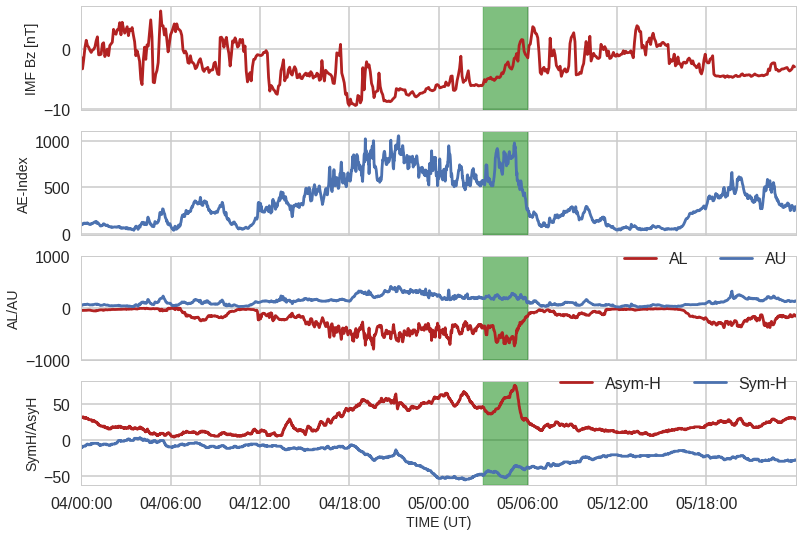

In [10]:
# Setup Fig
sns.set_style("whitegrid")
sns.set_context("poster")
f = plt.figure(figsize=(12, 8))
f, axArr = plt.subplots(4, sharex=True)
axArr[0].plot(omnDF["date"].values, omnDF["Bz"].values, color='firebrick')
axArr[1].plot(aeDF["date"].values, aeDF["ae"].values)
axArr[2].plot(aeDF["date"].values, aeDF["al"].values, color='firebrick', label="AL")
axArr[2].plot(aeDF["date"].values, aeDF["au"].values, label="AU")
axArr[3].plot(symDF["date"].values, symDF["asyh"].values, color='firebrick', label="Asym-H")
axArr[3].plot(symDF["date"].values, symDF["symh"].values, label="Sym-H")
# axArr[4].plot(symDF["date"].values, symDF["asyd"].values, color='firebrick', label="Asym-D")
# axArr[4].plot(symDF["date"].values, symDF["symd"].values, label="Sym-D")
# axArr[5].plot(wpDF["date"].values, wpDF["Wp"].values, label="Sym-D")

# ax labels
axArr[0].set_ylabel("IMF Bz [nT]", fontsize=14)
axArr[1].set_ylabel("AE-Index", fontsize=14)
axArr[2].set_ylabel("AL/AU", fontsize=14)
axArr[3].set_ylabel("SymH/AsyH", fontsize=14)
# axArr[4].set_ylabel("SymD/AsyD", fontsize=14)
# x-label
axArr[-1].set_xlabel("TIME (UT)", fontsize=14)

# format the axes
axArr[0].set_xlim( [gmagTimeRange[0], gmagTimeRange[1] ] )
axArr[1].set_xlim( [gmagTimeRange[0], gmagTimeRange[1] ] )
axArr[2].set_xlim( [gmagTimeRange[0], gmagTimeRange[1] ] )
axArr[3].set_xlim( [gmagTimeRange[0], gmagTimeRange[1]] )
# axArr[4].set_xlim( [gmagTimeRange[0], gmagTimeRange[1]] )

axArr[0].get_xaxis().set_major_formatter(DateFormatter('%d/%H:%M'))
axArr[1].get_xaxis().set_major_formatter(DateFormatter('%d/%H:%M'))
axArr[2].get_xaxis().set_major_formatter(DateFormatter('%d/%H:%M'))
axArr[3].get_xaxis().set_major_formatter(DateFormatter('%d/%H:%M'))
# axArr[4].get_xaxis().set_major_formatter(DateFormatter('%d/%H:%M'))

# set y limits
axArr[2].set_ylim( [-1000, 1000] )
# axArr[1].set_ylim( [0, 1000] )
# if startDate.strftime("%Y%m%d") == "20110516":
#     axArr[2].set_ylim( [-600, 600] )
# else:
#     axArr[2].set_ylim( [-750, 750] )
# axArr[3].set_ylim( [-60, 60] )

# plot legend
axArr[2].legend( bbox_to_anchor=(0., 1.02, 1., .102), loc=1, ncol=2, borderaxespad=0.1 )
axArr[3].legend( bbox_to_anchor=(0., 1.02, 1., .102), loc=1, ncol=2, borderaxespad=0.1 )
# axArr[4].legend( bbox_to_anchor=(0., 1.02, 1., .102), loc=1, ncol=2, borderaxespad=0.1 )

# plot vertical lines
highLighDtList = [ datetime.datetime(2011,7,5,3,0),\
              datetime.datetime(2011,7,5,6,0) ]
for nd in range(len(highLighDtList)-1):
    for axx in axArr:
        axx.axvspan(highLighDtList[nd], highLighDtList[nd+1],\
                   alpha=0.5, color='green')
# #     axx.plot( [sd, sd], list(axx.get_ylim()), c='k' )
#         axx.axvspan( x=sd, c='k', linestyle=":", linewidth=3. )

f.savefig( "../plots/gmag-expand-" + startDate.strftime("%Y%m%d") + ".pdf",bbox_inches='tight' )

In [11]:
# read TEC data from the feather file
tecDF = feather.read_dataframe('../data/tec-mf-' +\
                endDate.strftime("%Y%m%d") + '.feather')
# Get the min loc of trough at diff MLONs
trghLocsDF = tecDF[ (tecDF["med_tec"] <= 20.) &\
                  (tecDF["Mlat"] >= trghLatRange[0]) &\
                  (tecDF["Mlat"] <= trghLatRange[1]) ]
trghLocsDF["time"] = [ date2num(x) for x in trghLocsDF["date"] ]
trghMinDF = trghLocsDF[ ["time", "Mlon", "med_tec"]\
                 ].groupby( [ "time", "Mlon" ]\
                ).min().reset_index()
trghMinDF["Mlon2"] = [x-360 if x>180 else x for x in trghMinDF["Mlon"] ]

trghMinDF.head()

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


,time,Mlon,med_tec,Mlon2
0,734323.125,0.0,4.6,0.0
1,734323.125,2.0,4.6,2.0
2,734323.125,4.0,4.2,4.0
3,734323.125,6.0,4.0,6.0
4,734323.125,8.0,4.9,8.0


In [12]:
# A different type of TEC trough plot
selDF = tecDF[ ((tecDF["date"] >= startDate) &\
                       (tecDF["date"] <= endDate) &\
                    (tecDF["Mlat"] <= trghLatRange[1]) &\
                       (tecDF["Mlat"] >= trghLatRange[0]) )]
selDF["time"] = [ date2num(x) for x in selDF["date"] ]
selDF = selDF[ ["Mlat", "time", "med_tec"]\
             ].groupby( ["Mlat", "time"] ).median().reset_index()

plotmedFiltTECDF = selDF[ ["Mlat", "time",\
                        "med_tec"] ].pivot( "Mlat", "time" )

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


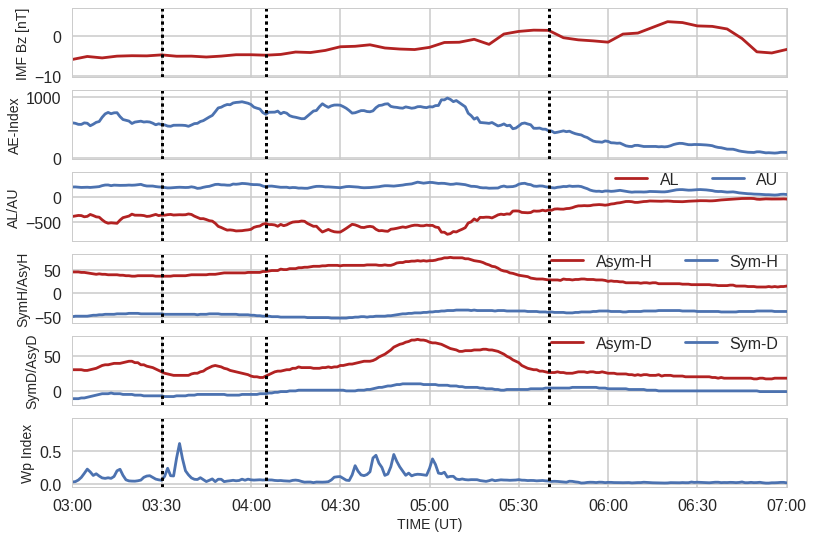

In [13]:
# Setup Fig
sns.set_style("whitegrid")
sns.set_context("poster")
f = plt.figure(figsize=(12, 8))
f, axArr = plt.subplots(6, sharex=True)
axArr[0].plot(omnDF["date"].values, omnDF["Bz"].values, color='firebrick')
axArr[1].plot(aeDF["date"].values, aeDF["ae"].values)
axArr[2].plot(aeDF["date"].values, aeDF["al"].values, color='firebrick', label="AL")
axArr[2].plot(aeDF["date"].values, aeDF["au"].values, label="AU")
axArr[3].plot(symDF["date"].values, symDF["asyh"].values, color='firebrick', label="Asym-H")
axArr[3].plot(symDF["date"].values, symDF["symh"].values, label="Sym-H")
axArr[4].plot(symDF["date"].values, symDF["asyd"].values, color='firebrick', label="Asym-D")
axArr[4].plot(symDF["date"].values, symDF["symd"].values, label="Sym-D")
axArr[5].plot(wpDF["date"].values, wpDF["Wp"].values, label="Sym-D")

# ax labels
axArr[0].set_ylabel("IMF Bz [nT]", fontsize=14)
axArr[1].set_ylabel("AE-Index", fontsize=14)
axArr[2].set_ylabel("AL/AU", fontsize=14)
axArr[3].set_ylabel("SymH/AsyH", fontsize=14)
axArr[4].set_ylabel("SymD/AsyD", fontsize=14)
axArr[5].set_ylabel("Wp Index", fontsize=14)
# x-label
axArr[5].set_xlabel("TIME (UT)", fontsize=14)

# format the axes
axArr[0].set_xlim( [startDate, endDate] )
axArr[1].set_xlim( [startDate, endDate] )
axArr[2].set_xlim( [startDate, endDate] )
axArr[3].set_xlim( [startDate, endDate] )

axArr[0].get_xaxis().set_major_formatter(DateFormatter('%H:%M'))
axArr[1].get_xaxis().set_major_formatter(DateFormatter('%H:%M'))
axArr[2].get_xaxis().set_major_formatter(DateFormatter('%H:%M'))
axArr[3].get_xaxis().set_major_formatter(DateFormatter('%H:%M'))
axArr[4].get_xaxis().set_major_formatter(DateFormatter('%H:%M'))
axArr[5].get_xaxis().set_major_formatter(DateFormatter('%H:%M'))

# set y limits
# axArr[1].set_ylim( [0, 1000] )
# if startDate.strftime("%Y%m%d") == "20110516":
#     axArr[2].set_ylim( [-600, 600] )
# else:
#     axArr[2].set_ylim( [-750, 750] )
# axArr[3].set_ylim( [-60, 60] )

# plot legend
axArr[2].legend( bbox_to_anchor=(0., 1.02, 1., .102), loc=1, ncol=2, borderaxespad=0.1 )
axArr[3].legend( bbox_to_anchor=(0., 1.02, 1., .102), loc=1, ncol=2, borderaxespad=0.1 )
axArr[4].legend( bbox_to_anchor=(0., 1.02, 1., .102), loc=1, ncol=2, borderaxespad=0.1 )

# plot vertical lines
for sd in selDtList:
    for axx in axArr:
#     axx.plot( [sd, sd], list(axx.get_ylim()), c='k' )
        axx.axvline( x=sd, c='k', linestyle=":", linewidth=3. )

f.savefig( "../plots/gmag-" + startDate.strftime("%Y%m%d") + ".eps",bbox_inches='tight' )

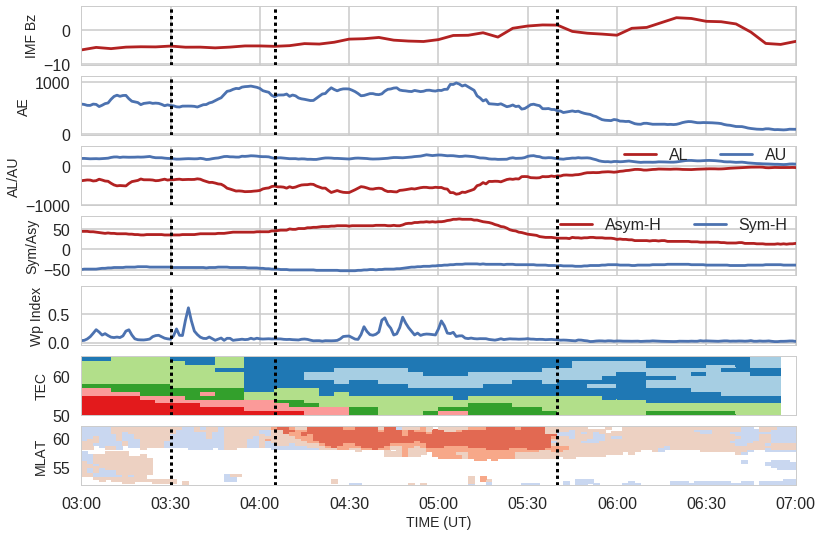

In [14]:
# Setup Fig
sns.set_style("whitegrid")
sns.set_context("poster")
f = plt.figure(figsize=(12, 8))
f, axArr = plt.subplots(7, sharex=True)
axArr[0].plot(omnDF["date"].values, omnDF["Bz"].values, color='firebrick')
axArr[1].plot(aeDF["date"].values, aeDF["ae"].values)
axArr[2].plot(aeDF["date"].values, aeDF["al"].values, color='firebrick', label="AL")
axArr[2].plot(aeDF["date"].values, aeDF["au"].values, label="AU")
axArr[3].plot(symDF["date"].values, symDF["asyh"].values, color='firebrick', label="Asym-H")
axArr[3].plot(symDF["date"].values, symDF["symh"].values, label="Sym-H")
axArr[4].plot(wpDF["date"].values, wpDF["Wp"].values, label="Sym-D")
# TEC
plotDF = trghMinDF[ ["time", "Mlon2",\
                        "med_tec"] ].pivot( "time", "Mlon2" )

timeValsTec = plotDF.index.values
mlonValsTec = plotDF.columns.levels[1].values

timeCntrTec, mlonCntrTec  = numpy.meshgrid( timeValsTec, mlonValsTec )
# Mask the nan values! pcolormesh can't handle them well!
# tecVals = numpy.ma.masked_where(\
#                 numpy.isnan(plotDF["med_tec"].values),\
#                 plotDF["med_tec"].values)
# tecPlot = axArr[5].pcolormesh(timeCntrTec.T, mlonCntrTec.T , tecVals,\
#                         cmap=ListedColormap(sns.color_palette("Paired")),\
#                         vmin=tecScale[0],vmax=tecScale[1])

seaMapTec = ListedColormap(sns.color_palette("Paired"))
mlatValsTec = plotmedFiltTECDF.index.values
timeValsTec = plotmedFiltTECDF.columns.levels[1].values
mlatCntrTec, timeCntrTec  = numpy.meshgrid( mlatValsTec, timeValsTec )
med_tecVals = numpy.ma.masked_where(numpy.isnan(plotmedFiltTECDF["med_tec"].values),plotmedFiltTECDF["med_tec"].values)
tecPlot = axArr[5].pcolormesh(timeCntrTec, mlatCntrTec,med_tecVals.T,cmap=seaMapTec)

# SD RTI
rtiPlot = axArr[6].pcolormesh(timeCntr, mlatCntr, vLosVals,\
                        cmap=velSeaMap, vmin=velScale[0],\
                        vmax=velScale[1])


# ax labels
axArr[0].set_ylabel("IMF Bz", fontsize=14)
axArr[1].set_ylabel("AE", fontsize=14)
axArr[2].set_ylabel("AL/AU", fontsize=14)
axArr[3].set_ylabel("Sym/Asy", fontsize=14)
axArr[4].set_ylabel("Wp Index", fontsize=14)
axArr[5].set_ylabel("TEC", fontsize=14)
axArr[6].set_ylabel("MLAT", fontsize=14)
# x-label
axArr[-1].set_xlabel("TIME (UT)", fontsize=14)

# format the axes
axArr[-1].set_ylim( sapsMlatRange )

# set y limits
axArr[2].set_ylim( [ -1000, 500 ] )
# if startDate.strftime("%Y%m%d") == "20110516":
#     axArr[2].set_ylim( [-600, 600] )
# else:
#     axArr[2].set_ylim( [-750, 750] )
# axArr[3].set_ylim( [-60, 60] )

# plot legend
axArr[2].legend( bbox_to_anchor=(0., 1.02, 1., .102), loc=1, ncol=2, borderaxespad=0.1 )
axArr[3].legend( bbox_to_anchor=(0., 1.02, 1., .102), loc=1, ncol=2, borderaxespad=0.1 )

# plot vertical lines
for sd in selDtList:
    for axx in axArr:
        axx.get_xaxis().set_major_formatter(DateFormatter('%H:%M'))
        axx.set_xlim( [startDate, endDate] )
        axx.axvline( x=sd, c='k', linestyle=":", linewidth=3. )

f.savefig( "../plots/gmag-rti-" + startDate.strftime("%Y%m%d") + ".eps",bbox_inches='tight' )

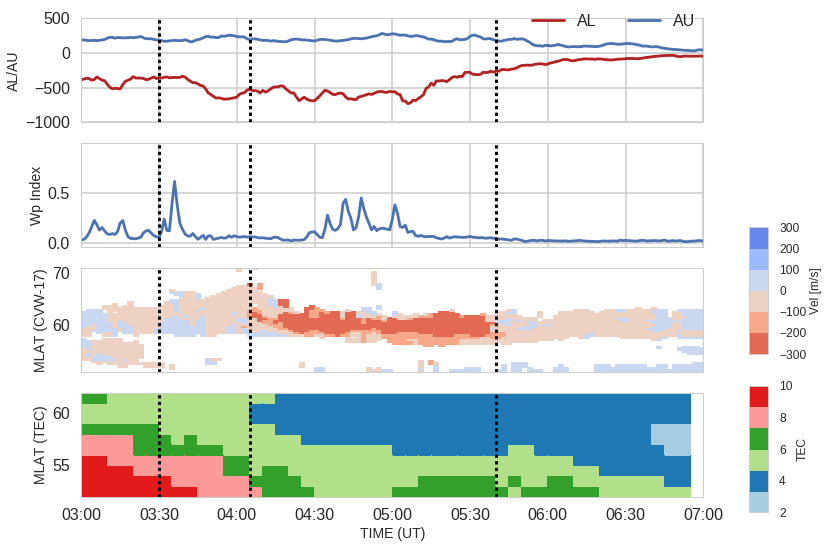

In [15]:
# Setup Fig
sns.set_style("whitegrid")
sns.set_context("poster")
f = plt.figure(figsize=(12, 8))
f, axArr = plt.subplots(4, sharex=True)
# axArr[0].plot(omnDF["date"].values, omnDF["Bz"].values, color='firebrick')
# axArr[1].plot(aeDF["date"].values, aeDF["ae"].values)
axArr[0].plot(aeDF["date"].values, aeDF["al"].values, color='firebrick', label="AL")
axArr[0].plot(aeDF["date"].values, aeDF["au"].values, label="AU")
# axArr[3].plot(symDF["date"].values, symDF["asyh"].values, color='firebrick', label="Asym-H")
# axArr[3].plot(symDF["date"].values, symDF["symh"].values, label="Sym-H")
axArr[1].plot(wpDF["date"].values, wpDF["Wp"].values, label="Sym-D")
# SD RTI
rtiPlot = axArr[2].pcolormesh(timeCntr, mlatCntr, vLosVals,\
                        cmap=velSeaMap, vmin=velScale[0],\
                        vmax=velScale[1])
# TEC
plotDF = trghMinDF[ ["time", "Mlon2",\
                        "med_tec"] ].pivot( "time", "Mlon2" )

timeValsTec = plotDF.index.values
mlonValsTec = plotDF.columns.levels[1].values

timeCntrTec, mlonCntrTec  = numpy.meshgrid( timeValsTec, mlonValsTec )
# Mask the nan values! pcolormesh can't handle them well!
# tecVals = numpy.ma.masked_where(\
#                 numpy.isnan(plotDF["med_tec"].values),\
#                 plotDF["med_tec"].values)
# tecPlot = axArr[5].pcolormesh(timeCntrTec.T, mlonCntrTec.T , tecVals,\
#                         cmap=ListedColormap(sns.color_palette("Paired")),\
#                         vmin=tecScale[0],vmax=tecScale[1])

seaMapTec = ListedColormap(sns.color_palette("Paired"))
mlatValsTec = plotmedFiltTECDF.index.values
timeValsTec = plotmedFiltTECDF.columns.levels[1].values
mlatCntrTec, timeCntrTec  = numpy.meshgrid( mlatValsTec, timeValsTec )
med_tecVals = numpy.ma.masked_where(numpy.isnan(plotmedFiltTECDF["med_tec"].values),plotmedFiltTECDF["med_tec"].values)
tecPlot = axArr[3].pcolormesh(timeCntrTec, mlatCntrTec,med_tecVals.T,\
                              cmap=seaMapTec, vmin=tecScale[0], vmax=tecScale[1])




# ax labels
axArr[0].set_ylabel("AL/AU", fontsize=14)
axArr[1].set_ylabel("Wp Index", fontsize=14)
axArr[2].set_ylabel("MLAT (CVW-17)", fontsize=14)
axArr[3].set_ylabel("MLAT (TEC)", fontsize=14)
# x-label
axArr[-1].set_xlabel("TIME (UT)", fontsize=14)

# format the axes
axArr[-1].set_ylim( sapsMlatRange )

# set y limits
axArr[0].set_ylim( [ -1000, 500 ] )
# if startDate.strftime("%Y%m%d") == "20110516":
#     axArr[2].set_ylim( [-600, 600] )
# else:
#     axArr[2].set_ylim( [-750, 750] )
# axArr[3].set_ylim( [-60, 60] )

# plot legend
axArr[0].legend( bbox_to_anchor=(0., 1.02, 1., .102), loc=1, ncol=2, borderaxespad=0.1 )
# axArr[3].legend( bbox_to_anchor=(0., 1.02, 1., .102), loc=1, ncol=2, borderaxespad=0.1 )

# plot vertical lines
for sd in selDtList:
    for axx in axArr:
        axx.get_xaxis().set_major_formatter(DateFormatter('%H:%M'))
        axx.set_xlim( [startDate, endDate] )
        axx.axvline( x=sd, c='k', linestyle=":", linewidth=3. )

# divider = make_axes_locatable(axArr[3])
# cax = divider.append_axes('right', size='5%', pad=0.9)
f.subplots_adjust(right=0.8)
cbarAxTEC = f.add_axes([0.85, 0.1, 0.02, 0.2])
cbarTEC =f.colorbar(tecPlot, cax=cbarAxTEC,\
                    ticks=range(tecScale[0], tecScale[1]+1,2))
cbarTEC.set_label("TEC", fontsize=12) 
cbarTEC.ax.tick_params(labelsize=12)


cbarAxRTI = f.add_axes([0.85, 0.35, 0.02, 0.2])
cbarRTI =f.colorbar(rtiPlot, cax=cbarAxRTI)
# cbarRTI = plt.colorbar(rtiPlot, orientation='vertical', ax=cax)
cbarRTI.set_label("Vel [m/s]", fontsize=12) 
cbarRTI.ax.tick_params(labelsize=12)
        
f.savefig( "../plots/gmag-tec-rti-" + startDate.strftime("%Y%m%d") + ".pdf",bbox_inches='tight' )

In [16]:
print 